In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline

### A function that returns all result file pathes in the output folder

In [20]:
"""
Return a list of result file pathes in the output folder

output_path: output folder name
"""
def get_result_file_pathes(output_path):
    results = os.listdir(output_path)
    results = [output_path + '/' + result for result in results]
    return results

### A function that generates precision scores and write the results to a new file.

In [56]:
"""
Return the result dataframe containing precision scores calculated.

input_path: raw result file's path
output_path: processed result file's path
"""
def process_row_data(input_path, output_path, sample_id):
    results = pd.read_csv(input_path)
    results.columns = results.columns.str.strip()
    results['sample_id'] = str(id)
    results['w_support'] = (results['ww'] + results['wm'])
    results['m_support'] = (results['mm'] + results['mw'])

    results['w_precision'] = results['ww'] / (results['ww'] + results['mw'])
    results['w_recall'] = results['ww'] / (results['ww'] + results['wm'])
    results['m_precision'] = results['mm'] / (results['mm'] + results['wm'])
    results['m_recall'] = results['mm'] / (results['mm'] + results['mw'])
    results = results.fillna(0)
    
    results['w_f1'] = ( 2 * results['w_precision'] * results['w_recall'] )/ (results['w_precision'] + results['w_recall'])
    results['m_f1'] = ( 2 * results['m_precision'] * results['m_recall'] )/ (results['m_precision'] + results['m_recall'])
    results = results.fillna(0)
    
    results['precision'] = ((results['w_precision'] * results['w_support']) + (results['m_precision'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results['recall'] = ((results['w_recall'] * results['w_support']) + (results['m_recall'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results['f1'] = ((results['w_f1'] * results['w_support']) + (results['m_f1'] * results['m_support']))/ (results['w_support'] + results['m_support'])
    results = results.fillna(0)
    
    results.to_csv(output_path)
    
    return results

### Analysis Distribution of Overall Scores

In [86]:
def analyse_result(file_path, show_distribution, show_voting):
    results = pd.read_csv(file_path)

    if show_distribution:
        # the histogram of the data
        plt.figure(figsize=(15, 15)) 
        plt.subplot(3, 3, 1)
        plt.hist(results.precision, 50, facecolor='b', alpha=0.5, normed=True, range=[0, 1])
        plt.xlabel('precision')
        plt.title('Overall Precision')
        plt.grid(True)

        plt.subplot(3, 3, 2)
        plt.hist(results.recall, 50, facecolor='r', alpha=0.5, normed=True, range=[0, 1])
        plt.xlabel('recall')
        plt.title('Overall Recall')
        plt.grid(True)

        plt.subplot(3, 3, 3)
        plt.hist(results.f1, 50, facecolor='g', alpha=0.5, normed=True, range=[0, 1])
        plt.xlabel('F1')
        plt.title('Overall F1')
        plt.grid(True)

        plt.subplot(3, 3, 4)
        plt.hist(results.w_precision, 50, facecolor='b', alpha=0.5, range=[0, 1])
        plt.xlabel('precision')
        plt.title('WT Precision')
        plt.grid(True)

        plt.subplot(3, 3, 5)
        plt.hist(results.w_recall, 50, facecolor='r', alpha=0.5, range=[0, 1])
        plt.xlabel('recall')
        plt.title('WT Recall')
        plt.grid(True)

        plt.subplot(3, 3, 6)
        plt.hist(results.w_f1, 50, facecolor='g', alpha=0.5, range=[0, 1])
        plt.xlabel('f1')
        plt.title('WT F1')
        plt.grid(True)

        plt.subplot(3, 3, 7)
        plt.hist(results.m_precision, 50, facecolor='b', alpha=0.5, range=[0, 1])
        plt.xlabel('precision')
        plt.title('MT Precision')
        plt.grid(True)

        plt.subplot(3, 3, 8)
        plt.hist(results.m_recall, 50, facecolor='r', alpha=0.5, range=[0, 1])
        plt.xlabel('recall')
        plt.title('MT Recall')
        plt.grid(True)

        plt.subplot(3, 3, 9)
        plt.hist(results.m_f1, 50, facecolor='g', alpha=0.5, range=[0, 1])
        plt.xlabel('F1')
        plt.title('MT F1')
        plt.grid(True)

        plt.show()
    
    vote0 = results[(results.pred == 0)].shape[0]
    vote1 = results[(results.pred == 1)].shape[0]
    prediction = 1 if vote1 > vote0 else 0

    if show_voting:
        print('votes for type 0 (no threshold): ', vote0)
        print('votes for type 1 (no threshold): ', vote1)
        #print('votes for type 0 (m_f1>0.5): ', results[(results.pred == 0) & (results.m_f1 > 0.5)].shape)
        #print('votes for type 1 (m_f1>0.5): ', results[(results.pred == 1) & (results.m_f1 > 0.5)].shape)
    
    return prediction

### Testing

In [64]:
input_folder = 'output_AT_2med'
output_folder = 'analysis_AT_2med'
# get result file names
result_files = get_result_file_pathes(os.path.join(os.getcwd(), input_folder))

In [65]:
results = []
for result_file in result_files:
    # get sample id
    name = result_file.split('/')[-1]
    id = ''.join(x for x in name if x.isdigit())
    print('processing: ' + id)
    
    # generate output file path
    output_path = os.path.join(os.getcwd(), output_folder, 'AT_2med_'+id+'.csv')

    # process raw result and append the dataframe to the results list
    results.append(process_row_data(result_file, output_path, id))

processing: 113
processing: 107
processing: 106
processing: 104
processing: 110
processing: 111
processing: 105
processing: 101
processing: 115
processing: 317
processing: 114
processing: 128
processing: 116
processing: 102
processing: 103
processing: 117
processing: 6
processing: 4
processing: 5
processing: 1
processing: 2
processing: 3
processing: 126
processing: 324
processing: 318
processing: 21
processing: 319
processing: 325
processing: 127
processing: 125
processing: 119
processing: 326
processing: 118
processing: 124
processing: 108
processing: 120
processing: 323
processing: 121
processing: 109
processing: 123
processing: 321
processing: 19
processing: 24
processing: 320
processing: 122


In [68]:
aggregated_result = pd.concat(results)
aggregated_result.to_csv(output_folder + '/AT_2med_aggregated.csv')

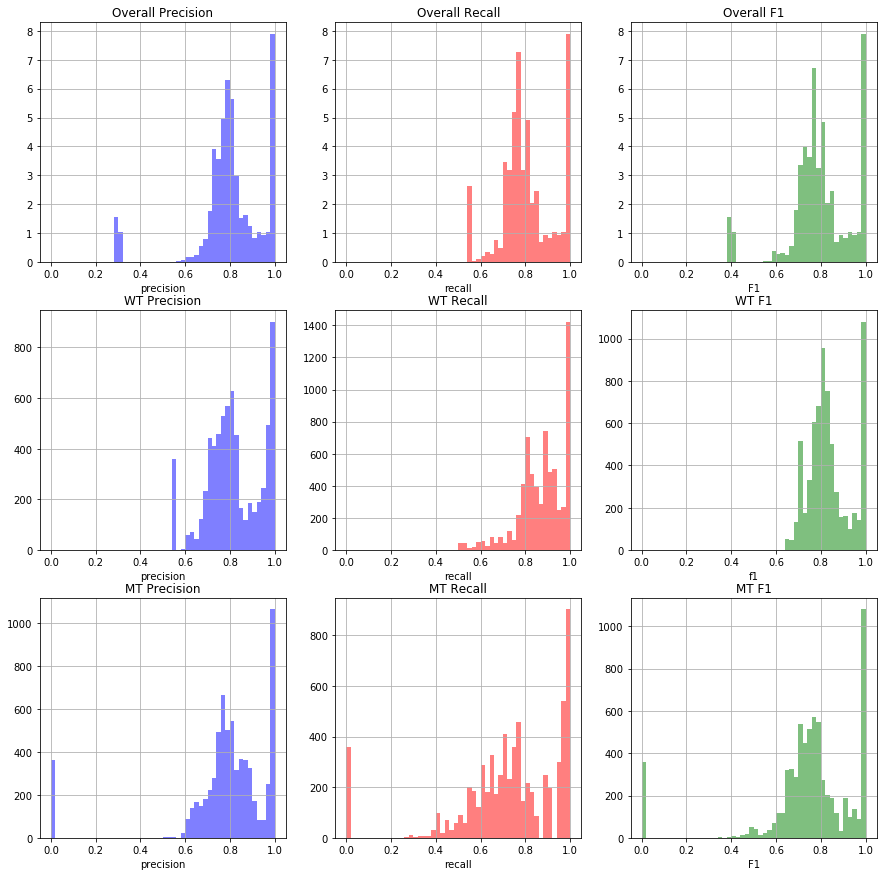

In [75]:
analyse_result(output_folder + '/AT_2med_aggregated.csv', True, False)

In [91]:
for result_file in result_files:
    # get sample id
    name = result_file.split('/')[-1]
    id = ''.join(x for x in name if x.isdigit())
    print('processing: ' + id)

    # generate output file path
    output_path = os.path.join(os.getcwd(), output_folder, 'AT_2med_'+id+'.csv')

    # process raw result and append the dataframe to the results list
    print('prediction(no threshold): ' + str(analyse_result(output_path, False, True)) + '\n')

processing: 113
votes for type 0 (no threshold):  141
votes for type 1 (no threshold):  11
prediction(no threshold): 0

processing: 107
votes for type 0 (no threshold):  137
votes for type 1 (no threshold):  15
prediction(no threshold): 0

processing: 106
votes for type 0 (no threshold):  143
votes for type 1 (no threshold):  9
prediction(no threshold): 0

processing: 104
votes for type 0 (no threshold):  144
votes for type 1 (no threshold):  8
prediction(no threshold): 0

processing: 110
votes for type 0 (no threshold):  132
votes for type 1 (no threshold):  20
prediction(no threshold): 0

processing: 111
votes for type 0 (no threshold):  132
votes for type 1 (no threshold):  20
prediction(no threshold): 0

processing: 105
votes for type 0 (no threshold):  131
votes for type 1 (no threshold):  21
prediction(no threshold): 0

processing: 101
votes for type 0 (no threshold):  132
votes for type 1 (no threshold):  20
prediction(no threshold): 0

processing: 115
votes for type 0 (no thres